# Support Vector Machines (SVM)

[Support Vector Machines](https://en.wikipedia.org/wiki/Support-vector_machine), or SVMs, can often do better than other models at fitting data — especially data is that is highly non-linear. The diagram on the left in the illustration below shows a 2D set of data points that a conventional linear model will not fit. In other words, there is no line you can draw to separate the blue points from the green points. However, SVM can use a "kernel trick" to add a third dimension to each data point based on its distance from the center. In 3D space (below right), you can then draw a plane that cleanly separates the two classes of data points.

![](Images/svm.png)

That's a simple way to visualize how Support Vector Machines work. Let's learn about SVM by using the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset that is provided with scikit-learn to build a facial-recognition model.

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100)
print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In total, 1,140 facial images were loaded. Each image measures 62 by 47 pixels for a total of 2,914 pixels per image. That basically means we're working with a model with 2,914 feature columns. Use the following code to show the first 24 images in the dataset and the people to whom the faces belong.

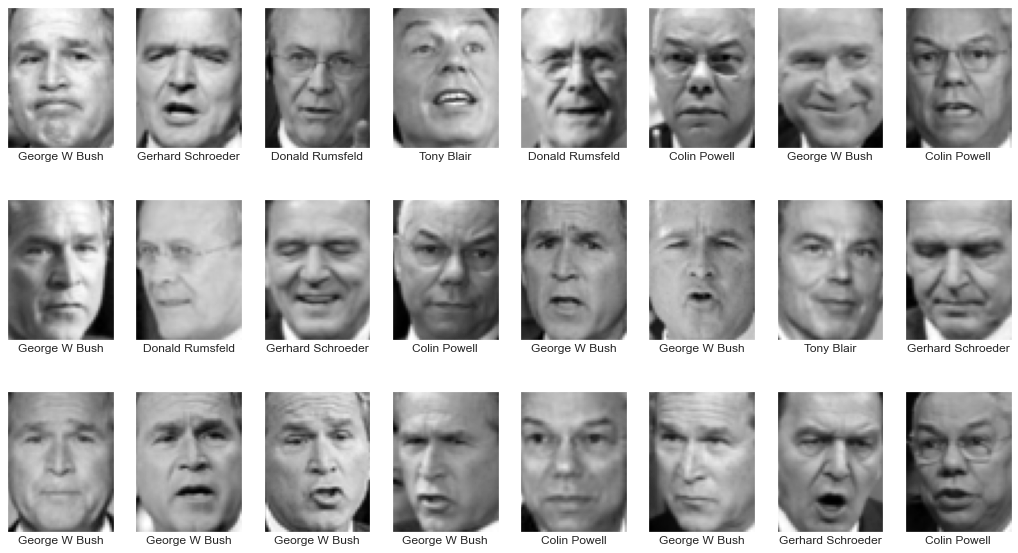

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each person.

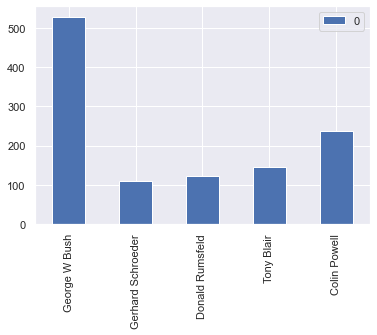

In [3]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

There are far more images of George W. Bush than of anyone else in the dataset. Classification models are best trained with balanced datasets. Use the following code to build a dataset containing 100 images of each person.

In [4]:
mask = np.zeros(faces.target.shape, dtype=np.bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
    
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 2914)

Finish up by using `train_to_split` to generate a training dataset and a test dataset.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_faces, y_faces, train_size=0.8, stratify=y_faces, random_state=0)

C:\Users\Jeff\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Note the `stratify` parameter, whose purpose is make sure that all five individuals are equally represented in the training dataset and the test dataset.

## Train an SVM model

The next task is to train an SVM model to do image classification using the faces in the dataset. Start by creating an SVM classifier and training it with the 80% of the dataset reserved for training.

In [6]:
from sklearn.svm import SVC

model = SVC(gamma='auto', random_state=0)
model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

Next, use the 20% of the dataset set aside for testing to assess the accuracy of the model.

In [7]:
model.score(x_test, y_test)

0.26

The results probably weren't what you expected, but we're far from done. SVM models tend to be very sensitive to data that isn't normalized. Show the first 100 pixel values in the first image:

In [8]:
print(x_train[0][:100])

[ 94.666664 104.       133.66667  159.33333  166.       176.66667
 189.33333  199.33333  194.33333  189.       191.33333  201.33333
 203.66667  201.66667  199.       199.66667  205.33333  209.
 210.66667  210.       211.33333  213.66667  213.       211.
 211.       208.66667  202.66667  197.66667  197.33333  195.33333
 190.33333  182.66667  176.33333  178.       178.33333  174.66667
 173.66667  176.66667  189.66667  198.66667  178.       176.33333
 186.66667  190.       202.       219.       228.       114.666664
 132.       156.       171.33333  174.33333  182.33333  192.66667
 200.66667  197.66667  190.       189.33333  198.66667  203.
 200.       200.       202.       205.66667  208.       210.33333
 209.66667  211.       214.       213.66667  210.66667  210.66667
 210.       208.33333  205.66667  204.66667  204.33333  203.66667
 197.       190.       188.33333  188.       186.       184.33333
 186.33333  195.66667  207.66667  189.33333  172.       171.33333
 147.66667  122.       1

The pixel values range from 0 to 255. Let's normalize them using Scikit's [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) class and examine the values again.

In [9]:
from sklearn.preprocessing import MinMaxScaler

print(MinMaxScaler().fit_transform(x_train)[0][:100])

[0.42696625 0.47551346 0.6203554  0.7066052  0.73129773 0.7297688
 0.8018018  0.843609   0.8095238  0.7543352  0.7665197  0.82649845
 0.7961905  0.76447105 0.715431   0.7131474  0.74418604 0.75908214
 0.769962   0.76769507 0.77817523 0.79272723 0.7912088  0.78442025
 0.7888087  0.77196264 0.73473287 0.69105697 0.69959676 0.70114934
 0.72667754 0.67012095 0.6339755  0.66178864 0.6687697  0.6473354
 0.64724416 0.68453294 0.7695783  0.79601234 0.6832845  0.68111885
 0.73485875 0.7510149  0.79892755 0.8753351  0.91176474 0.52236426
 0.6268657  0.68844986 0.7325409  0.766055   0.77861446 0.81570995
 0.8426627  0.81911767 0.7771085  0.7754442  0.80402935 0.76673424
 0.7219827  0.6959315  0.69556034 0.7046414  0.71367526 0.72647697
 0.7185501  0.7342799  0.75992066 0.76422757 0.74437624 0.74849105
 0.75717014 0.7485605  0.72489965 0.7226721  0.7646016  0.79454255
 0.7692308  0.740566   0.73248404 0.72275645 0.70720005 0.6979332
 0.7205651  0.78345865 0.8256334  0.7209653  0.65625    0.6684931

By default, `MinMaxScaler` scales the pixel values to values from 0.0 to 1.0. Now let's do the same with [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which centers values around 0.0 with a standard deviation of 1.0.

In [10]:
from sklearn.preprocessing import StandardScaler

print(StandardScaler().fit_transform(x_train)[0][:100])

[0.20413533 0.32949752 0.8693447  1.250732   1.1592155  1.1803722
 1.3529817  1.5202452  1.3193749  1.0820099  1.0602862  1.270224
 1.281466   1.1562387  1.0156964  0.9968843  1.1642383  1.2732425
 1.3083426  1.2578573  1.2756326  1.3513222  1.3047231  1.2046436
 1.2006626  1.1081007  0.91060936 0.7610235  0.7734441  0.71555275
 0.5711165  0.3631305  0.21728651 0.34168163 0.42150176 0.39078844
 0.45486525 0.65464175 1.1234058  1.4860613  1.098387   1.2450496
 1.6366535  1.8232398  2.1313298  2.4896924  2.6868572  0.58496314
 0.881369   1.267466   1.3880283  1.2226039  1.2236034  1.384716
 1.5445889  1.3709346  1.0448083  0.9237616  1.1242187  1.1962968
 1.0329267  0.9876071  1.0238407  1.128713   1.1822526  1.237529
 1.192449   1.227697   1.3318677  1.3018049  1.1630753  1.1619704
 1.1371524  1.0926137  1.0177876  1.0054806  0.9967484  0.98992103
 0.8065749  0.6369924  0.65169895 0.7036283  0.7134637  0.7455114
 0.9012475  1.2740669  1.7113979  1.3443239  1.0674119  1.2393304
 0.857035

Create a pipeline that transforms pixel data with `MinMaxScaler` and fits it with SVC, and then train the model.

In [11]:
from sklearn.pipeline import make_pipeline

scaler = MinMaxScaler()
svc = SVC(gamma='auto', random_state=0)
model = make_pipeline(scaler, svc)
model.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))])

Score the model again.

In [12]:
model.score(x_test, y_test)

0.44

That's better, but now let's replace `MinMaxScaler` with `StandardScaler`.

In [13]:
scaler = StandardScaler()
svc = SVC(gamma='auto', random_state=0)
model = make_pipeline(scaler, svc)
model.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))])

Does that improve the accuracy further?

In [14]:
model.score(x_test, y_test)

0.74

SVM can use several types of kernels to fit a mathematical model to a dataset. The default kernel type is one called the [radial-basis function](https://en.wikipedia.org/wiki/Radial_basis_function), which Scikit-learn abbreviates `rbf`. You can specify the kernel type with the `SVC` class's `kernel` parameter. Use the following statements to train a model with normalized data using a linear kernel:

In [15]:
scaler = StandardScaler()
svc = SVC(kernel='linear', gamma='auto', random_state=0)
model = make_pipeline(scaler, svc)
model.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))])

Score the model a final time.

In [16]:
model.score(x_test, y_test)

0.88

Now we're getting somewhere!

## Analyze the model's performance

The `score` function gives you a rough estimate of the model's accuracy, but you can learn more from other metrics such as [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). Start by printing a classification report to get a more detailed assessment of the model's accuracy.

In [17]:
from sklearn.metrics import classification_report

y_predicted = model.predict(x_test)
print(classification_report(y_test, y_predicted, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.86      0.95      0.90        20
  Donald Rumsfeld       0.74      1.00      0.85        20
    George W Bush       1.00      0.85      0.92        20
Gerhard Schroeder       0.94      0.80      0.86        20
       Tony Blair       0.94      0.80      0.86        20

        micro avg       0.88      0.88      0.88       100
        macro avg       0.90      0.88      0.88       100
     weighted avg       0.90      0.88      0.88       100



Observe that George W. Bush achieved a precision of 1.0. This tells you that all of the images predicted to be George W. Bush actually were George W. Bush. But the recall score of 0.85 indicates that images of George W. Bush were sometimes misclassified as other people. For clarity, generate a confusion matrix to see how the model *really* performed during testing.

Text(89.18, 0.5, 'Predicted label')

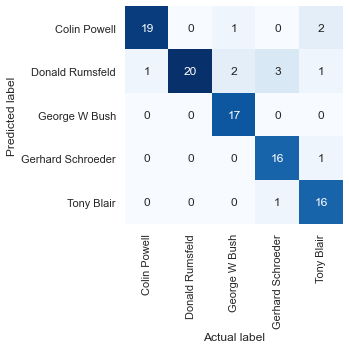

In [18]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

The model correctly identified Colin Powell 19 times out of 20, Donald Rumsfeld 20 times out of 20, and so on. That's not bad. And it's a great example of Support Vector Machines at work. It would be challenging, perhaps impossible, to do this well using more conventional learning algorithms such as logistic regression.

## Cross-validate the model

Currently, we are using a randomly selected 20% of the faces in the dataset to test the model and quantify its accuracy. Unfortunately, you can (and almost always will) get different results depending on which 20% of the dataset you select. For a more reliable measure of accuracy, you can *cross-validate* the model by training it several times, each time using different subsets of the original dataset for training and testing, and averaging the scores from each run. (This is precisely what `GridSearchCV` does when evaluating the effect of different parameter combinations.) Scikit's [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function makes this easy. Let's finish up by using it to measure the accuracy of our model. We'll divide the original dataset into five *folds* and train the model five times, each time using a different fold for testing and the remaining folds for training.

In [19]:
from sklearn.model_selection import cross_validate

scores = cross_validate(model, x_faces, y_faces, cv=5)
print(scores['test_score'].mean())

0.8560000000000001


The cross-validated score is lower than the score returned by the model's `score` method. That's OK, because the CV score is probably a more accurate indicator of how well the model will respond to faces it hasn't seen before. And to a data scientist, accuracy is everything.